In [134]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder
from PIL import Image 
import glob
import os

In [135]:
import tensorflow as tf
import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

In [136]:
import os
os.environ["WANDB_AGENT_MAX_INITIAL_FAILURES"] = "10"

import wandb
# wandb 관련 코드


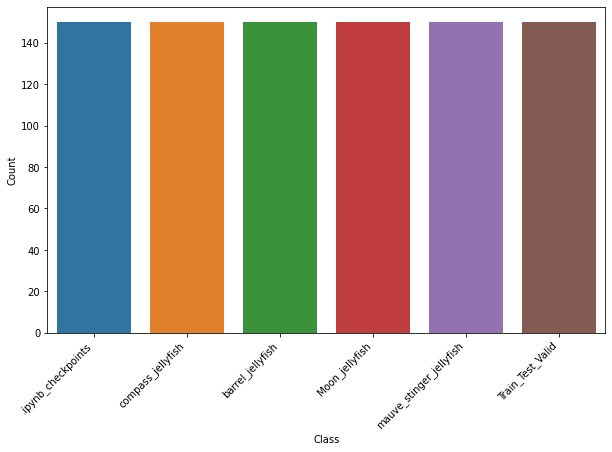

In [137]:
def load_data(data_directory):
    images = []
    labels = []
    classes = []
    label_encoder = LabelEncoder()

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        classes.append(class_name)

        for filename in os.listdir(class_path):
            filepath = os.path.join(class_path, filename)
            img = cv2.imread(filepath)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, (224, 224))
                img = img / 255.0
                images.append(img)
                labels.append(class_name)

    images = np.array(images)
    labels = label_encoder.fit_transform(labels) 

    return images, labels, classes

# Update the path to your dataset
data_directory = './jellyfish/'
images, labels, classes = load_data(data_directory)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=[classes[label] for label in labels])  
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
classes = np.unique(classes)

In [138]:
datagen = ImageDataGenerator(
    rotation_range=30,         # Randomly rotate images by 20 degrees
    #brightness_range=[0., 0.5],  # Adjust brightness between 10% and 200%
    width_shift_range=0.1,     # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.1,    # Randomly shift images vertically by 20% of the height
    shear_range=0.1,           # Shear intensity
    zoom_range=0.3,            # Randomly zoom into images
    horizontal_flip=True,      # Randomly flip images horizontally
    vertical_flip=True,        # Randomly flip images vertically
)
datagen1 = ImageDataGenerator()

train_generator = datagen.flow(X_train, y_train, batch_size=20)
val_generator = datagen1.flow(X_test, y_test, batch_size=20)

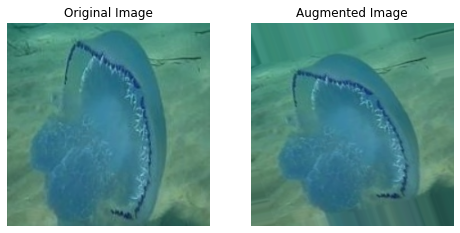

In [140]:
index = np.random.randint(0, len(X_train))

# Select the original image
original_image = (X_train[index] * 255).astype(np.uint8)

# Reshape the selected image to (1, height, width, channels) to make it a batch of size 1
original_image = np.expand_dims(original_image, axis=0)

# Create an iterator for the batch (with only one sample)
iterator = datagen.flow(original_image, batch_size=1)

# Generate augmented images
augmented_images = next(iterator).astype(np.uint8)

# Display the original and augmented images
plt.figure(figsize=(8, 4))

# Original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image[0])
plt.axis('off')

# Augmented image
plt.subplot(1, 2, 2)
plt.title('Augmented Image')
plt.imshow(augmented_images[0])  # vmax, vmin 제거
plt.axis('off')

plt.show()


In [141]:
wandb.login(key = "c4e33984a0f1d0c7e209f455add7b4da4718e070")

#import os
#import wandb

#wandb.login(key=os.getenv("WANDB_API_KEY"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [142]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [143]:
def train():
    default_config = {
        "input" : (28,28,1),
        "filter" : 16,
        "kernel" : (3,3),
        "activation" : "relu",
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config = default_config)
    config = wandb.config

    # Model

    #define the convnet
    global model 
    model = Sequential()
    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # FLATTERN => DENSE => RELU => DROPOUT
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(6, activation='softmax'))


    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # WandbCallback 함수는 후술합니다.
    
    history = model.fit(train_generator, epochs=wandb.config.epoch, validation_data=val_generator)
    
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Find the epoch with the highest validation accuracy
    best_epoch = val_accuracy.index(max(val_accuracy)) + 1  # Add 1 because epochs are 1-indexed

    print(f"Best Accuracy: {accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")
    print(f"Best Validation Accuracy: {val_accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})
    

In [144]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = "wisdom-jihyekim-aiffel",
                       project = "WandB_with_second_CNN_used_by_Jindeok")

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)


Create sweep with ID: p274bdy2
Sweep URL: https://wandb.ai/wisdom-jihyekim-aiffel/WandB_with_second_CNN_used_by_Jindeok/sweeps/p274bdy2


wandb: Agent Starting Run: we4sn3o6 with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.005504299766120083


Epoch 1/10
36/36 [==============================] - 7s 194ms/step - loss: 2.9438 - accuracy: 0.2417 - val_loss: 1.7219 - val_accuracy: 0.3000
Epoch 2/10
36/36 [==============================] - 7s 195ms/step - loss: 1.6158 - accuracy: 0.3319 - val_loss: 1.5581 - val_accuracy: 0.4000
Epoch 3/10
36/36 [==============================] - 7s 190ms/step - loss: 1.4754 - accuracy: 0.4083 - val_loss: 1.4629 - val_accuracy: 0.3833
Epoch 4/10
36/36 [==============================] - 7s 191ms/step - loss: 1.4022 - accuracy: 0.4292 - val_loss: 1.3250 - val_accuracy: 0.4444
Epoch 5/10
36/36 [==============================] - 7s 191ms/step - loss: 1.3188 - accuracy: 0.4528 - val_loss: 1.2195 - val_accuracy: 0.5222
Epoch 6/10
36/36 [==============================] - 7s 195ms/step - loss: 1.2239 - accuracy: 0.5153 - val_loss: 1.2450 - val_accuracy: 0.4833
Epoch 7/10
36/36 [==============================] - 7s 192ms/step - loss: 1.1873 - accuracy: 0.5375 - val_loss: 1.2185 - val_accuracy: 0.4778
Epoch 

Run we4sn3o6 errored: NameError("name 'test_accuracy' is not defined")
wandb: ERROR Run we4sn3o6 errored: NameError("name 'test_accuracy' is not defined")
wandb: Agent Starting Run: tkdv6ns3 with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.06093737227903509


Epoch 1/8
36/36 [==============================] - 8s 203ms/step - loss: 3.0298 - accuracy: 0.2139 - val_loss: 1.7605 - val_accuracy: 0.2333
Epoch 2/8
36/36 [==============================] - 7s 194ms/step - loss: 1.6249 - accuracy: 0.3014 - val_loss: 1.5708 - val_accuracy: 0.2889
Epoch 3/8
36/36 [==============================] - 7s 193ms/step - loss: 1.4634 - accuracy: 0.4042 - val_loss: 1.4720 - val_accuracy: 0.3611
Epoch 4/8
36/36 [==============================] - 7s 192ms/step - loss: 1.3797 - accuracy: 0.4514 - val_loss: 1.5069 - val_accuracy: 0.3889
Epoch 5/8
36/36 [==============================] - 7s 193ms/step - loss: 1.3345 - accuracy: 0.4764 - val_loss: 1.3067 - val_accuracy: 0.4556
Epoch 6/8
36/36 [==============================] - 7s 193ms/step - loss: 1.2529 - accuracy: 0.5028 - val_loss: 1.2471 - val_accuracy: 0.5278
Epoch 7/8
36/36 [==============================] - 7s 197ms/step - loss: 1.1721 - accuracy: 0.5375 - val_loss: 1.2566 - val_accuracy: 0.5056
Epoch 8/8
36/

Run tkdv6ns3 errored: NameError("name 'test_accuracy' is not defined")
wandb: ERROR Run tkdv6ns3 errored: NameError("name 'test_accuracy' is not defined")
wandb: Agent Starting Run: eg5mh5n2 with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.03496870932879006


Epoch 1/6
36/36 [==============================] - 8s 197ms/step - loss: 2.3084 - accuracy: 0.2403 - val_loss: 1.6731 - val_accuracy: 0.2778
Epoch 2/6
36/36 [==============================] - 7s 192ms/step - loss: 1.6336 - accuracy: 0.2931 - val_loss: 1.6058 - val_accuracy: 0.3056
Epoch 3/6
36/36 [==============================] - 7s 192ms/step - loss: 1.4909 - accuracy: 0.3625 - val_loss: 1.5338 - val_accuracy: 0.2944
Epoch 4/6
36/36 [==============================] - 7s 194ms/step - loss: 1.4169 - accuracy: 0.4139 - val_loss: 1.4821 - val_accuracy: 0.4222
Epoch 5/6
36/36 [==============================] - 7s 191ms/step - loss: 1.3669 - accuracy: 0.4542 - val_loss: 1.2982 - val_accuracy: 0.4667
Epoch 6/6
36/36 [==============================] - 7s 191ms/step - loss: 1.2789 - accuracy: 0.4639 - val_loss: 1.2737 - val_accuracy: 0.4611
Best Accuracy: 0.4542 at Epoch 5
Best Validation Accuracy: 0.4667 at Epoch 5


Run eg5mh5n2 errored: NameError("name 'test_accuracy' is not defined")
wandb: ERROR Run eg5mh5n2 errored: NameError("name 'test_accuracy' is not defined")
wandb: Agent Starting Run: mnqxey9d with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.03310261076031264


Epoch 1/9
36/36 [==============================] - 8s 195ms/step - loss: 2.6464 - accuracy: 0.2458 - val_loss: 1.6289 - val_accuracy: 0.3167
Epoch 2/9
36/36 [==============================] - 7s 190ms/step - loss: 1.5776 - accuracy: 0.3667 - val_loss: 1.5278 - val_accuracy: 0.3222
Epoch 3/9
36/36 [==============================] - 7s 193ms/step - loss: 1.4687 - accuracy: 0.4056 - val_loss: 1.4178 - val_accuracy: 0.3944
Epoch 4/9
36/36 [==============================] - 7s 192ms/step - loss: 1.3723 - accuracy: 0.4597 - val_loss: 1.3633 - val_accuracy: 0.4611
Epoch 5/9
36/36 [==============================] - 7s 193ms/step - loss: 1.2807 - accuracy: 0.4792 - val_loss: 1.2865 - val_accuracy: 0.4444
Epoch 6/9
36/36 [==============================] - 7s 191ms/step - loss: 1.2411 - accuracy: 0.5056 - val_loss: 1.2139 - val_accuracy: 0.4944
Epoch 7/9
36/36 [==============================] - 7s 194ms/step - loss: 1.2346 - accuracy: 0.5292 - val_loss: 1.2028 - val_accuracy: 0.4944
Epoch 8/9
36/

Run mnqxey9d errored: NameError("name 'test_accuracy' is not defined")
wandb: ERROR Run mnqxey9d errored: NameError("name 'test_accuracy' is not defined")
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y3nvlbqt with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.033735494449384125


Epoch 1/8
36/36 [==============================] - 8s 196ms/step - loss: 2.1562 - accuracy: 0.1931 - val_loss: 1.7287 - val_accuracy: 0.2611
Epoch 2/8
36/36 [==============================] - 7s 192ms/step - loss: 1.6073 - accuracy: 0.3458 - val_loss: 1.5076 - val_accuracy: 0.3778
Epoch 3/8
36/36 [==============================] - 7s 191ms/step - loss: 1.4215 - accuracy: 0.4375 - val_loss: 1.5310 - val_accuracy: 0.3889
Epoch 4/8
36/36 [==============================] - 7s 193ms/step - loss: 1.3364 - accuracy: 0.4653 - val_loss: 1.2826 - val_accuracy: 0.4778
Epoch 5/8
36/36 [==============================] - 7s 193ms/step - loss: 1.2764 - accuracy: 0.4986 - val_loss: 1.2072 - val_accuracy: 0.5111
Epoch 6/8
36/36 [==============================] - 7s 191ms/step - loss: 1.2436 - accuracy: 0.5181 - val_loss: 1.2259 - val_accuracy: 0.5000
Epoch 7/8
36/36 [==============================] - 7s 191ms/step - loss: 1.2011 - accuracy: 0.5264 - val_loss: 1.3594 - val_accuracy: 0.4389
Epoch 8/8
36/

Run y3nvlbqt errored: NameError("name 'test_accuracy' is not defined")
wandb: ERROR Run y3nvlbqt errored: NameError("name 'test_accuracy' is not defined")
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lifei1sa with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.09332579438969477


Epoch 1/7
36/36 [==============================] - 8s 194ms/step - loss: 2.4076 - accuracy: 0.2111 - val_loss: 1.7314 - val_accuracy: 0.2778
Epoch 2/7
36/36 [==============================] - 7s 195ms/step - loss: 1.6202 - accuracy: 0.3417 - val_loss: 1.5417 - val_accuracy: 0.3944
Epoch 3/7
36/36 [==============================] - 7s 192ms/step - loss: 1.4674 - accuracy: 0.3903 - val_loss: 1.4837 - val_accuracy: 0.3667
Epoch 4/7
36/36 [==============================] - 7s 192ms/step - loss: 1.4218 - accuracy: 0.4319 - val_loss: 1.3825 - val_accuracy: 0.4500
Epoch 5/7
36/36 [==============================] - 7s 193ms/step - loss: 1.3491 - accuracy: 0.4694 - val_loss: 1.3771 - val_accuracy: 0.4444
Epoch 6/7
36/36 [==============================] - 7s 193ms/step - loss: 1.2601 - accuracy: 0.4889 - val_loss: 1.2841 - val_accuracy: 0.4722
Epoch 7/7
36/36 [==============================] - 7s 195ms/step - loss: 1.2420 - accuracy: 0.5250 - val_loss: 1.2236 - val_accuracy: 0.4722
Best Accuracy

Run lifei1sa errored: NameError("name 'test_accuracy' is not defined")
wandb: ERROR Run lifei1sa errored: NameError("name 'test_accuracy' is not defined")
wandb: Agent Starting Run: dljwuyrv with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.09893045821863931


Epoch 1/10
36/36 [==============================] - 7s 194ms/step - loss: 2.1170 - accuracy: 0.1639 - val_loss: 1.7613 - val_accuracy: 0.2611
Epoch 2/10
36/36 [==============================] - 7s 192ms/step - loss: 1.7225 - accuracy: 0.2514 - val_loss: 1.7106 - val_accuracy: 0.3833
Epoch 3/10
36/36 [==============================] - 7s 195ms/step - loss: 1.6302 - accuracy: 0.3278 - val_loss: 1.5765 - val_accuracy: 0.3833
Epoch 4/10
36/36 [==============================] - 7s 191ms/step - loss: 1.5509 - accuracy: 0.3875 - val_loss: 1.5561 - val_accuracy: 0.3778
Epoch 5/10
36/36 [==============================] - 7s 192ms/step - loss: 1.5342 - accuracy: 0.3778 - val_loss: 1.4777 - val_accuracy: 0.4000
Epoch 6/10
36/36 [==============================] - 7s 192ms/step - loss: 1.4501 - accuracy: 0.4181 - val_loss: 1.4159 - val_accuracy: 0.4556
Epoch 7/10
36/36 [==============================] - 7s 191ms/step - loss: 1.3690 - accuracy: 0.4389 - val_loss: 1.5759 - val_accuracy: 0.4111
Epoch 

Run dljwuyrv errored: NameError("name 'test_accuracy' is not defined")
wandb: ERROR Run dljwuyrv errored: NameError("name 'test_accuracy' is not defined")
wandb: Agent Starting Run: i4w79rhv with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.02710767166644143


Epoch 1/8
36/36 [==============================] - 7s 194ms/step - loss: 2.5269 - accuracy: 0.1833 - val_loss: 1.7575 - val_accuracy: 0.2278
Epoch 2/8
36/36 [==============================] - 7s 191ms/step - loss: 1.6942 - accuracy: 0.2611 - val_loss: 1.6909 - val_accuracy: 0.2944
Epoch 3/8
36/36 [==============================] - 7s 190ms/step - loss: 1.5672 - accuracy: 0.3153 - val_loss: 1.5391 - val_accuracy: 0.4389
Epoch 4/8
36/36 [==============================] - 7s 192ms/step - loss: 1.4773 - accuracy: 0.3958 - val_loss: 1.4635 - val_accuracy: 0.4278
Epoch 5/8
36/36 [==============================] - 7s 190ms/step - loss: 1.3760 - accuracy: 0.4750 - val_loss: 1.3360 - val_accuracy: 0.4167
Epoch 6/8
36/36 [==============================] - 7s 191ms/step - loss: 1.2764 - accuracy: 0.4944 - val_loss: 1.3848 - val_accuracy: 0.3944
Epoch 7/8
36/36 [==============================] - 7s 191ms/step - loss: 1.2166 - accuracy: 0.5222 - val_loss: 1.2409 - val_accuracy: 0.5389
Epoch 8/8
36/

Run i4w79rhv errored: NameError("name 'test_accuracy' is not defined")
wandb: ERROR Run i4w79rhv errored: NameError("name 'test_accuracy' is not defined")
wandb: Agent Starting Run: udoh3cxv with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.027151913570697447


Epoch 1/8
36/36 [==============================] - 7s 194ms/step - loss: 2.1853 - accuracy: 0.2417 - val_loss: 1.7393 - val_accuracy: 0.2833
Epoch 2/8
36/36 [==============================] - 7s 191ms/step - loss: 1.6061 - accuracy: 0.3292 - val_loss: 1.5702 - val_accuracy: 0.4000
Epoch 3/8
36/36 [==============================] - 7s 191ms/step - loss: 1.5466 - accuracy: 0.3722 - val_loss: 1.5517 - val_accuracy: 0.3444
Epoch 4/8
36/36 [==============================] - 7s 188ms/step - loss: 1.4077 - accuracy: 0.4569 - val_loss: 1.3769 - val_accuracy: 0.4333
Epoch 5/8
36/36 [==============================] - 7s 192ms/step - loss: 1.3119 - accuracy: 0.4681 - val_loss: 1.2836 - val_accuracy: 0.4556
Epoch 6/8
36/36 [==============================] - 7s 191ms/step - loss: 1.2822 - accuracy: 0.4806 - val_loss: 1.3932 - val_accuracy: 0.3944
Epoch 7/8
36/36 [==============================] - 7s 193ms/step - loss: 1.2595 - accuracy: 0.5056 - val_loss: 1.2007 - val_accuracy: 0.5389
Epoch 8/8
36/

Run udoh3cxv errored: NameError("name 'test_accuracy' is not defined")
wandb: ERROR Run udoh3cxv errored: NameError("name 'test_accuracy' is not defined")
wandb: Agent Starting Run: bp7jr8te with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.02221687538992351


Epoch 1/9
36/36 [==============================] - 8s 197ms/step - loss: 2.1269 - accuracy: 0.2014 - val_loss: 1.7196 - val_accuracy: 0.2556
Epoch 2/9
36/36 [==============================] - 7s 193ms/step - loss: 1.5767 - accuracy: 0.3264 - val_loss: 1.5200 - val_accuracy: 0.3444
Epoch 3/9
36/36 [==============================] - 7s 190ms/step - loss: 1.4356 - accuracy: 0.4167 - val_loss: 1.4397 - val_accuracy: 0.4000
Epoch 4/9
36/36 [==============================] - 7s 191ms/step - loss: 1.3765 - accuracy: 0.4528 - val_loss: 1.3716 - val_accuracy: 0.4333
Epoch 5/9
36/36 [==============================] - 7s 188ms/step - loss: 1.2771 - accuracy: 0.4764 - val_loss: 1.3012 - val_accuracy: 0.4611
Epoch 6/9
36/36 [==============================] - 7s 192ms/step - loss: 1.2350 - accuracy: 0.4972 - val_loss: 1.2527 - val_accuracy: 0.4556
Epoch 7/9
36/36 [==============================] - 7s 189ms/step - loss: 1.2118 - accuracy: 0.5069 - val_loss: 1.3546 - val_accuracy: 0.4500
Epoch 8/9
36/

Run bp7jr8te errored: NameError("name 'test_accuracy' is not defined")
wandb: ERROR Run bp7jr8te errored: NameError("name 'test_accuracy' is not defined")


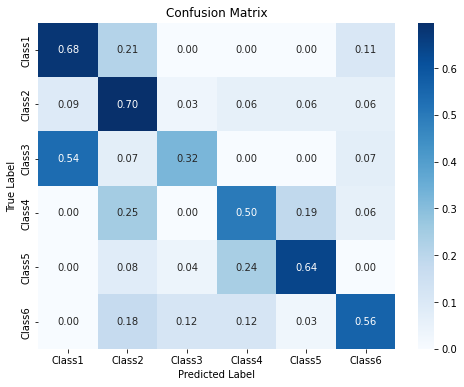

In [145]:
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true = y_test

conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Calculate class weights to account for imbalanced classes (optional)
weights = class_weight.compute_sample_weight('balanced', y_true)

# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Get class names from your data
classes = ["Class1", "Class2", "Class3", "Class4", "Class5", "Class6"]  # Replace with your actual class names

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

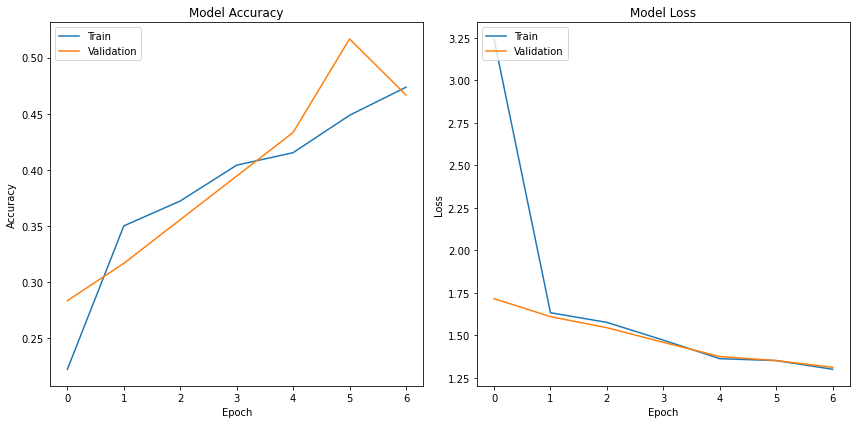

In [146]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()